### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Check what the max, min and mean time values are. This will help us in defining the 'next_step' function in the Environment.

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by  1 day.

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay =  -0.0005 #for 15k
        self.epsilon_min =  0.00001
        self.epsilon = 1
        
        self.batch_size = 32     
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()
        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))  
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform')) # the output layer: output is of size num_actions
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model 

    # get action in a state according to an epsilon-greedy approach
    # possible_actions_index, actions are the 'ride requests' that teh driver got.
    
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)] 
        
    
    # appends the new agent run output to replay buffer
    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory 
        
        self.memory.append((state, action_index, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    # Function to train the model on eacg step run.
    # Picks the random memory events according to batch size and runs it through the network to train it.
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], [] 
            
            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i] 
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                 
            # predict the target q-values from states s
            target = self.model.predict(update_input)
            
            # target for q-network
            target_qval = self.model.predict(update_output)
            
            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
    
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])
      
    #Defining a function to save the Q-dictionary as a pickle file
    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
        
 

### DQN block

for episode in range(Episodes):

#### Call the environment
#### initialise variables of the environment


#### Call the DQN agent


while !terminal_state:

    # Write your code here
    # 1. Pick epsilon-greedy action from possible actions for the current state
    # 2. Evaluate your reward and next state
    # 3. Append the experience to the memory
    # 4. Train the model by calling function agent.train_model
    # 5. Keep a track of rewards, Q-values, loss

In [6]:
Episodes = 15000
episode_time = 24*30 #30 days before which car has to be recharged 
m = 5
t = 24
d = 7

In [7]:

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

In [8]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    
    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode 9, reward -440.0, memory_length 1375, epsilon 0.9955001547284723 total_time 722.0
episode 19, reward -386.0, memory_length 2000, epsilon 0.9905350769930761 total_time 726.0
episode 29, reward 27.0, memory_length 2000, epsilon 0.9855947626861951 total_time 726.0
episode 39, reward -182.0, memory_length 2000, epsilon 0.9806790882997144 total_time 731.0
episode 49, reward -144.0, memory_length 2000, epsilon 0.9757879309415182 total_time 723.0
episode 59, reward -296.0, memory_length 2000, epsilon 0.9709211683324178 total_time 724.0
episode 69, reward -390.0, memory_length 2000, epsilon 0.9660786788030947 total_time 722.0
episode 79, reward -6.0, memory_length 2000, epsilon 0.9612603412910584 total_time 725.0
episode 89, reward -170.0, memory_length 2000, epsilon 0.9564660353376199 total_time 726.0
episode 99, reward -198.0, memory_length 2000, epsilon 0.9516956410848808 total_time 721.0
episode 109, reward -115.0, memory_length 2000, epsilon 0.9469490392727365 total

episode 919, reward 423.0, memory_length 2000, epsilon 0.631593050259626 total_time 729.0
episode 929, reward 540.0, memory_length 2000, epsilon 0.6284429667796988 total_time 730.0
episode 939, reward 198.0, memory_length 2000, epsilon 0.6253085944066726 total_time 732.0
episode 949, reward 664.0, memory_length 2000, epsilon 0.6221898547810748 total_time 721.0
episode 959, reward 123.0, memory_length 2000, epsilon 0.6190866699342522 total_time 726.0
episode 969, reward 613.0, memory_length 2000, epsilon 0.6159989622864221 total_time 721.0
episode 979, reward 375.0, memory_length 2000, epsilon 0.6129266546447325 total_time 725.0
episode 989, reward 214.0, memory_length 2000, epsilon 0.6098696702013323 total_time 725.0
episode 999, reward 414.0, memory_length 2000, epsilon 0.6068279325314512 total_time 721.0
Saving Model 1000
episode 1009, reward 767.0, memory_length 2000, epsilon 0.6038013655914889 total_time 726.0
episode 1019, reward 268.0, memory_length 2000, epsilon 0.60078989371711

episode 1809, reward 638.0, memory_length 2000, epsilon 0.40474015917966877 total_time 721.0
episode 1819, reward 828.0, memory_length 2000, epsilon 0.4027215092142031 total_time 728.0
episode 1829, reward 586.0, memory_length 2000, epsilon 0.4007129273074429 total_time 726.0
episode 1839, reward 1137.0, memory_length 2000, epsilon 0.39871436324473586 total_time 725.0
episode 1849, reward 509.0, memory_length 2000, epsilon 0.3967257670618763 total_time 723.0
episode 1859, reward 1105.0, memory_length 2000, epsilon 0.3947470890438561 total_time 724.0
episode 1869, reward 1023.0, memory_length 2000, epsilon 0.3927782797236218 total_time 728.0
episode 1879, reward 677.0, memory_length 2000, epsilon 0.3908192898808378 total_time 731.0
episode 1889, reward 1154.0, memory_length 2000, epsilon 0.388870070540656 total_time 722.0
episode 1899, reward 756.0, memory_length 2000, epsilon 0.38693057297249134 total_time 724.0
episode 1909, reward 1053.0, memory_length 2000, epsilon 0.385000748688803

episode 2689, reward 1269.0, memory_length 2000, epsilon 0.26066740358669477 total_time 721.0
episode 2699, reward 1366.0, memory_length 2000, epsilon 0.25936731948751673 total_time 724.0
episode 2709, reward 1098.0, memory_length 2000, epsilon 0.2580737195848345 total_time 725.0
episode 2719, reward 841.0, memory_length 2000, epsilon 0.25678657153858325 total_time 722.0
episode 2729, reward 1117.0, memory_length 2000, epsilon 0.2555058431699948 total_time 726.0
episode 2739, reward 1279.0, memory_length 2000, epsilon 0.25423150246079323 total_time 721.0
episode 2749, reward 1049.0, memory_length 2000, epsilon 0.2529635175523944 total_time 721.0
episode 2759, reward 1113.0, memory_length 2000, epsilon 0.25170185674510953 total_time 721.0
episode 2769, reward 1156.0, memory_length 2000, epsilon 0.25044648849735274 total_time 722.0
episode 2779, reward 1149.0, memory_length 2000, epsilon 0.2491973814248526 total_time 721.0
episode 2789, reward 1130.0, memory_length 2000, epsilon 0.247954

episode 3569, reward 1081.0, memory_length 2000, epsilon 0.16787930169900972 total_time 729.0
episode 3579, reward 1226.0, memory_length 2000, epsilon 0.16704200018866794 total_time 721.0
episode 3589, reward 1342.0, memory_length 2000, epsilon 0.166208874737031 total_time 725.0
episode 3599, reward 1369.0, memory_length 2000, epsilon 0.1653799045159192 total_time 727.0
episode 3609, reward 1444.0, memory_length 2000, epsilon 0.16455506880103385 total_time 722.0
episode 3619, reward 1174.0, memory_length 2000, epsilon 0.1637343469714391 total_time 722.0
episode 3629, reward 1404.0, memory_length 2000, epsilon 0.1629177185090465 total_time 731.0
episode 3639, reward 708.0, memory_length 2000, epsilon 0.16210516299810185 total_time 724.0
episode 3649, reward 945.0, memory_length 2000, epsilon 0.16129666012467522 total_time 731.0
episode 3659, reward 1189.0, memory_length 2000, epsilon 0.16049218967615253 total_time 722.0
episode 3669, reward 1393.0, memory_length 2000, epsilon 0.15969173

episode 4449, reward 1042.0, memory_length 2000, epsilon 0.10812038464016717 total_time 725.0
episode 4459, reward 1187.0, memory_length 2000, epsilon 0.10758113197207911 total_time 724.0
episode 4469, reward 912.0, memory_length 2000, epsilon 0.10704456883789358 total_time 721.0
episode 4479, reward 1221.0, memory_length 2000, epsilon 0.10651068182350425 total_time 723.0
episode 4489, reward 1481.0, memory_length 2000, epsilon 0.10597945758170793 total_time 733.0
episode 4499, reward 893.0, memory_length 2000, epsilon 0.10545088283187094 total_time 726.0
episode 4509, reward 966.0, memory_length 2000, epsilon 0.10492494435959693 total_time 725.0
episode 4519, reward 1597.0, memory_length 2000, epsilon 0.1044016290163968 total_time 724.0
episode 4529, reward 1427.0, memory_length 2000, epsilon 0.10388092371935967 total_time 728.0
episode 4539, reward 1181.0, memory_length 2000, epsilon 0.103362815450826 total_time 729.0
episode 4549, reward 1087.0, memory_length 2000, epsilon 0.1028472

episode 5329, reward 1368.0, memory_length 2000, epsilon 0.0696334655697859 total_time 721.0
episode 5339, reward 1742.0, memory_length 2000, epsilon 0.06928616721137094 total_time 726.0
episode 5349, reward 1461.0, memory_length 2000, epsilon 0.06894060101074495 total_time 723.0
episode 5359, reward 1602.0, memory_length 2000, epsilon 0.06859675832873488 total_time 722.0
episode 5369, reward 1548.0, memory_length 2000, epsilon 0.06825463056925578 total_time 729.0
episode 5379, reward 1415.0, memory_length 2000, epsilon 0.06791420917909581 total_time 724.0
episode 5389, reward 1422.0, memory_length 2000, epsilon 0.06757548564770255 total_time 728.0
episode 5399, reward 1454.0, memory_length 2000, epsilon 0.06723845150697004 total_time 726.0
episode 5409, reward 1352.0, memory_length 2000, epsilon 0.06690309833102723 total_time 723.0
episode 5419, reward 1607.0, memory_length 2000, epsilon 0.06656941773602718 total_time 730.0
episode 5429, reward 1431.0, memory_length 2000, epsilon 0.06

episode 6199, reward 1199.0, memory_length 2000, epsilon 0.045071281909517265 total_time 724.0
episode 6209, reward 1477.0, memory_length 2000, epsilon 0.04484648795318105 total_time 729.0
episode 6219, reward 1409.0, memory_length 2000, epsilon 0.04462281516137944 total_time 736.0
episode 6229, reward 1498.0, memory_length 2000, epsilon 0.044400257942280974 total_time 723.0
episode 6239, reward 1090.0, memory_length 2000, epsilon 0.04417881073194358 total_time 725.0
episode 6249, reward 1479.0, memory_length 2000, epsilon 0.04395846799417545 total_time 722.0
episode 6259, reward 1520.0, memory_length 2000, epsilon 0.043739224220396694 total_time 724.0
episode 6269, reward 1352.0, memory_length 2000, epsilon 0.04352107392950154 total_time 727.0
episode 6279, reward 1347.0, memory_length 2000, epsilon 0.04330401166772134 total_time 723.0
episode 6289, reward 1360.0, memory_length 2000, epsilon 0.04308803200848826 total_time 726.0
episode 6299, reward 1624.0, memory_length 2000, epsilon 

episode 7069, reward 1479.0, memory_length 2000, epsilon 0.029173048279943936 total_time 723.0
episode 7079, reward 1661.0, memory_length 2000, epsilon 0.029027547094634832 total_time 722.0
episode 7089, reward 1448.0, memory_length 2000, epsilon 0.02888277159951494 total_time 724.0
episode 7099, reward 1584.0, memory_length 2000, epsilon 0.028738718175189356 total_time 726.0
episode 7109, reward 1503.0, memory_length 2000, epsilon 0.028595383220314963 total_time 727.0
episode 7119, reward 1426.0, memory_length 2000, epsilon 0.02845276315151042 total_time 724.0
episode 7129, reward 1718.0, memory_length 2000, epsilon 0.028310854403266573 total_time 724.0
episode 7139, reward 1362.0, memory_length 2000, epsilon 0.028169653427857343 total_time 725.0
episode 7149, reward 1409.0, memory_length 2000, epsilon 0.028029156695250978 total_time 726.0
episode 7159, reward 1953.0, memory_length 2000, epsilon 0.027889360693021847 total_time 727.0
episode 7169, reward 1494.0, memory_length 2000, eps

episode 7939, reward 1359.0, memory_length 2000, epsilon 0.018882683382569338 total_time 725.0
episode 7949, reward 1523.0, memory_length 2000, epsilon 0.018788505606300788 total_time 724.0
episode 7959, reward 1292.0, memory_length 2000, epsilon 0.01869479754365095 total_time 723.0
episode 7969, reward 1180.0, memory_length 2000, epsilon 0.0186015568519134 total_time 722.0
episode 7979, reward 1384.0, memory_length 2000, epsilon 0.018508781200065983 total_time 726.0
episode 7989, reward 1279.0, memory_length 2000, epsilon 0.018416468268712564 total_time 725.0
episode 7999, reward 1442.0, memory_length 2000, epsilon 0.018324615750025048 total_time 728.0
Saving Model 8000
episode 8009, reward 1784.0, memory_length 2000, epsilon 0.018233221347685697 total_time 729.0
episode 8019, reward 1471.0, memory_length 2000, epsilon 0.018142282776829687 total_time 721.0
episode 8029, reward 1644.0, memory_length 2000, epsilon 0.01805179776398801 total_time 730.0
episode 8039, reward 1558.0, memory_

episode 8809, reward 1568.0, memory_length 2000, epsilon 0.012222093773158674 total_time 731.0
episode 8819, reward 1507.0, memory_length 2000, epsilon 0.012161135826156058 total_time 723.0
episode 8829, reward 1213.0, memory_length 2000, epsilon 0.01210048190818249 total_time 726.0
episode 8839, reward 1692.0, memory_length 2000, epsilon 0.01204013050288686 total_time 733.0
episode 8849, reward 1649.0, memory_length 2000, epsilon 0.011980080101480892 total_time 722.0
episode 8859, reward 1347.0, memory_length 2000, epsilon 0.011920329202701425 total_time 727.0
episode 8869, reward 1645.0, memory_length 2000, epsilon 0.011860876312772876 total_time 726.0
episode 8879, reward 1333.0, memory_length 2000, epsilon 0.011801719945369903 total_time 725.0
episode 8889, reward 2045.0, memory_length 2000, epsilon 0.011742858621580235 total_time 730.0
episode 8899, reward 1665.0, memory_length 2000, epsilon 0.011684290869867704 total_time 729.0
episode 8909, reward 1382.0, memory_length 2000, eps

episode 9679, reward 1602.0, memory_length 2000, epsilon 0.007910929457080072 total_time 721.0
episode 9689, reward 945.0, memory_length 2000, epsilon 0.007871473531807663 total_time 722.0
episode 9699, reward 1371.0, memory_length 2000, epsilon 0.007832214393783524 total_time 725.0
episode 9709, reward 1576.0, memory_length 2000, epsilon 0.007793151061527156 total_time 726.0
episode 9719, reward 1067.0, memory_length 2000, epsilon 0.00775428255845322 total_time 726.0
episode 9729, reward 1572.0, memory_length 2000, epsilon 0.007715607912847108 total_time 721.0
episode 9739, reward 1765.0, memory_length 2000, epsilon 0.007677126157840679 total_time 724.0
episode 9749, reward 1778.0, memory_length 2000, epsilon 0.007638836331388046 total_time 727.0
episode 9759, reward 1898.0, memory_length 2000, epsilon 0.007600737476241555 total_time 723.0
episode 9769, reward 1280.0, memory_length 2000, epsilon 0.007562828639927842 total_time 730.0
episode 9779, reward 1246.0, memory_length 2000, eps

episode 10539, reward 1727.0, memory_length 2000, epsilon 0.005146131559545177 total_time 722.0
episode 10549, reward 1829.0, memory_length 2000, epsilon 0.005120465121314752 total_time 725.0
episode 10559, reward 1499.0, memory_length 2000, epsilon 0.005094926694979046 total_time 722.0
episode 10569, reward 1916.0, memory_length 2000, epsilon 0.00506951564207608 total_time 723.0
episode 10579, reward 1289.0, memory_length 2000, epsilon 0.005044231327328204 total_time 731.0
episode 10589, reward 1381.0, memory_length 2000, epsilon 0.005019073118626231 total_time 722.0
episode 10599, reward 1577.0, memory_length 2000, epsilon 0.004994040387013635 total_time 725.0
episode 10609, reward 1730.0, memory_length 2000, epsilon 0.00496913250667082 total_time 722.0
episode 10619, reward 1712.0, memory_length 2000, epsilon 0.004944348854899481 total_time 728.0
episode 10629, reward 1463.0, memory_length 2000, epsilon 0.004919688812107034 total_time 721.0
episode 10639, reward 1283.0, memory_lengt

episode 11389, reward 1255.0, memory_length 2000, epsilon 0.003364385323933774 total_time 725.0
episode 11399, reward 1587.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 723.0
episode 11409, reward 1305.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 730.0
episode 11419, reward 1562.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 721.0
episode 11429, reward 1526.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 721.0
episode 11439, reward 946.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 726.0
episode 11449, reward 1170.0, memory_length 2000, epsilon 0.003264952710747684 total_time 730.0
episode 11459, reward 1552.0, memory_length 2000, epsilon 0.003248668691167922 total_time 723.0
episode 11469, reward 1989.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 728.0
episode 11479, reward 1476.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 730.0
episode 11489, reward 1443.0, memo

episode 12239, reward 1090.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 724.0
episode 12249, reward 1524.0, memory_length 2000, epsilon 0.002188563251372572 total_time 721.0
episode 12259, reward 1758.0, memory_length 2000, epsilon 0.002177647746618221 total_time 723.0
episode 12269, reward 1499.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 725.0
episode 12279, reward 1699.0, memory_length 2000, epsilon 0.00215597978950362 total_time 723.0
episode 12289, reward 1809.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 728.0
episode 12299, reward 1637.0, memory_length 2000, epsilon 0.002134527432164626 total_time 723.0
episode 12309, reward 1410.0, memory_length 2000, epsilon 0.002123881432182913 total_time 728.0
episode 12319, reward 1382.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 723.0
episode 12329, reward 1670.0, memory_length 2000, epsilon 0.002102748458835638 total_time 723.0
episode 12339, reward 1859.0, memory_

episode 13089, reward 1478.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 726.0
episode 13099, reward 1526.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 724.0
episode 13109, reward 1070.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 723.0
episode 13119, reward 1715.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 724.0
episode 13129, reward 1940.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 730.0
episode 13139, reward 1356.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 723.0
episode 13149, reward 1539.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 724.0
episode 13159, reward 1532.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 727.0
episode 13169, reward 1343.0, memory_length 2000, epsilon 0.001381604187748968 total_time 724.0
episode 13179, reward 1586.0, memory_length 2000, epsilon 0.001374713408115093 total_time 723.0
episode 13189, reward 1557.0, me

episode 13939, reward 1245.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 723.0
episode 13949, reward 2123.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 721.0
episode 13959, reward 1823.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 727.0
episode 13969, reward 1455.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 723.0
episode 13979, reward 1941.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 726.0
episode 13989, reward 1522.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 728.0
episode 13999, reward 1573.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 723.0
Saving Model 14000
episode 14009, reward 1827.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 723.0
episode 14019, reward 1414.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 724.0
episode 14029, reward 1661.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 731.0
episode 140

episode 14789, reward 1818.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 723.0
episode 14799, reward 1523.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 722.0
episode 14809, reward 1638.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 722.0
episode 14819, reward 1447.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 724.0
episode 14829, reward 1323.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 721.0
episode 14839, reward 1149.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 722.0
episode 14849, reward 1672.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 721.0
episode 14859, reward 1791.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 725.0
episode 14869, reward 1483.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 723.0
episode 14879, reward 1527.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 726.0
episode 14889, reward 1469.0, 

### The 'total_time' above must also include the 'last ride' time in each episode.
### Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. 
### So the total ride time per episode is limited to < 720

In [9]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [10]:
agent.states_tracked

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 922.82684,
 267.31775,
 288.3818,
 422.57294,
 430.46805,
 434.58667,
 410.7744,
 412.32388,
 411.218,
 430.20844,
 428.9844,
 424.00217,
 528.7547,
 446.94705,
 514.5677,
 525.5206,
 557.69666,
 566.5166,
 577.0078,
 460.09637,
 566.88654,
 542.6253,
 552.3734,
 582.6197,
 594.95593,
 601.80554,
 567.3932,
 588.62244,
 453.4451,
 511.84482,
 534.95825,
 473.54324,
 604.76166,
 564.85986,
 608.01776,
 561.4558,
 685.8651,
 527.3477,
 472.36526,
 562.6109,
 465.3041,
 503.55927,
 530.0784,
 520.3174,
 523.6151,
 603.37506,
 528.90283,
 561.577,
 603.80066,
 553.2038,
 582.67694,
 621.4767,
 640.24774,
 612.8616,
 702.47845,
 870.9291,
 730.00555,
 762.58655,
 694.8997,
 626.2726,
 634.11017,
 605.0563,
 636.40845,
 597.56396,
 581.3339,
 674.325,
 570.7354,
 606.6154,
 574.76154,
 615.9388,
 625.5912,
 625.21924,
 561.8564,
 620.7396,
 703.6547,
 594.7484,
 616.73645,
 616.25836,
 625.4846,
 627.89636,
 647.2

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### Plot the Q-Value convergence for state action pairs

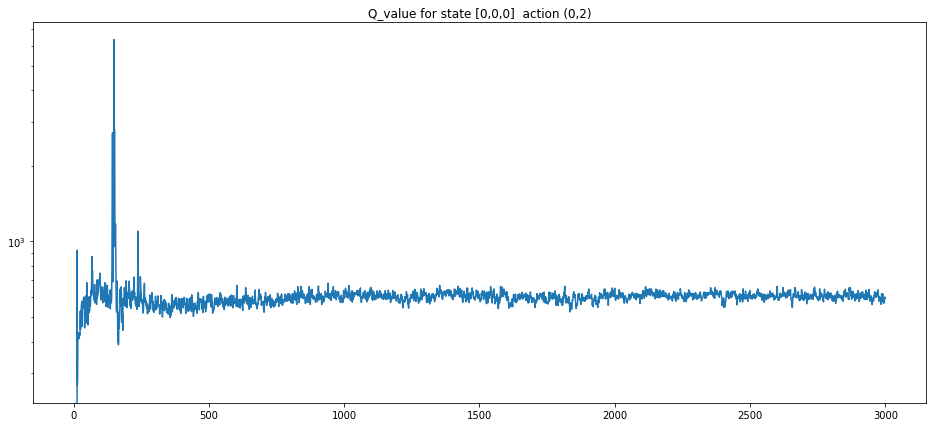

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### We are using log scale because the initial q_values are way to high compared to the steady state value (around 600

### Track rewards per episode.


In [13]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

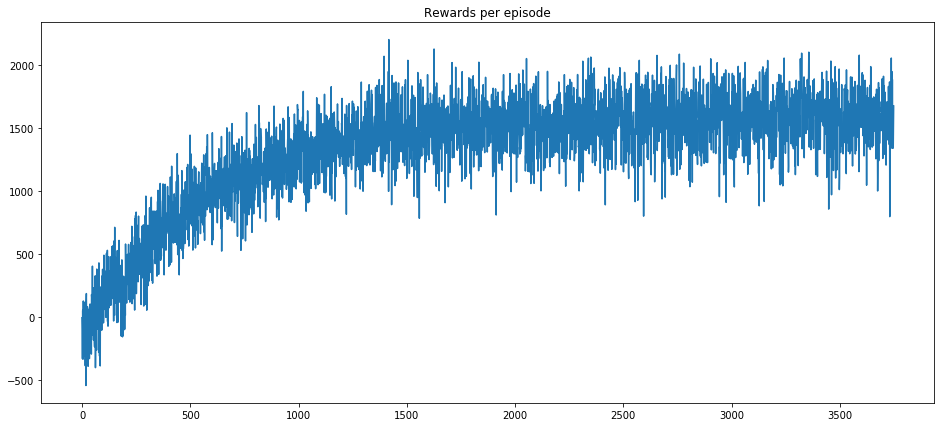

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### We can see from the above plot that the rewards converge at around 1500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.¶

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [17]:
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

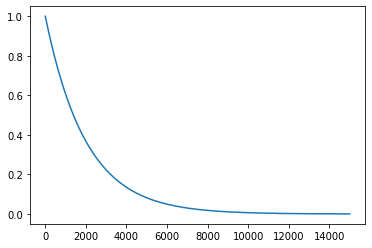

In [18]:
plt.plot(time, epsilon)
plt.show()